In [1]:
from __future__ import division
import scipy
import numpy as np
import math
import scipy.sparse as sparse
import scipy.sparse.linalg as lin
import matplotlib.pyplot as plt

## Define the required neural network functions.

In [2]:
class reservoir_parameters(object):
    """docstring for ClassName"""
    def __init__(self):
        self.radius = 0.
        self.degree = 0
        self.N = 0
        self.sigma = 0.
        self.train_length = 0
        self.predict_length = 0
        self.beta = 0


def generate_reservoir(size, radius, degree):
    sparsity = degree/size
    A = sparse.rand(size, size, sparsity)
    e = np.max(np.abs(lin.eigs(A, k = 1, return_eigenvectors = False)))
    A = (A/e)*radius
    return(A.tocsr())


def generate_input_layer(resparams):
    q = int(resparams.N/resparams.num_inputs)
    win = np.zeros((resparams.N, resparams.num_inputs))
    for i in range(resparams.num_inputs):
        ip = resparams.sigma*(-1 + 2*np.random.rand(q,))
        win[i*q:(i+1)*q,i] = ip

    return(win)


def train_reservoir(resparams, data):
#A = generate_reservoir(resparams.N, resparams.radius, resparams.degree)
    A = generate_reservoir(resparams.N, resparams.radius, resparams.degree)
    q = int(resparams.N/resparams.num_inputs)
    win = np.zeros((resparams.N, resparams.num_inputs))
    for i in range(resparams.num_inputs):
        ip = resparams.sigma*(-1 + 2*np.random.rand(q,))
        win[i*q:(i+1)*q,i] = ip
    states = reservoir_layer(A, win, data, resparams);
#data = data[:,1:resparams.train_length]
    return(states, A, win)


def reservoir_layer(A, win, input, resparams):
    states = np.zeros((resparams.N, resparams.train_length))
    for i in range(resparams.train_length - 1):
        states[:,i+1] = np.tanh(A.dot(states[:,i]) + np.dot(win,input[:,i]))
    return(states)

def squeven(x):
    x[::2] = x[::2]**2
    return(x)


## Load data for the Kuramoto-Sivashinsky Model

In [3]:
data = np.load('ksdata.npy')
num_inputs = data.shape[0]

## Examine the data and plot it

(64, 80000)


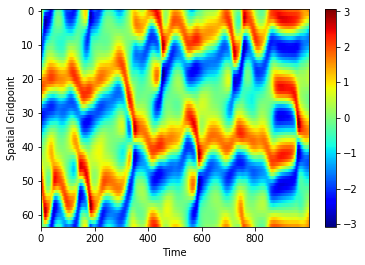

In [15]:
print(data.shape)
plt.imshow(data[:, 1000:2000], aspect = 'auto', cmap = 'jet')
plt.ylabel('Spatial Gridpoint')
plt.xlabel('Time')
plt.colorbar()

## Define the reservoir computer neural network parameters

In [4]:
resparams = reservoir_parameters()
resparams.radius = 0.6
resparams.degree = 3
approx_res_size = 5000
resparams.N = int(np.floor(approx_res_size/num_inputs)*num_inputs)
resparams.sigma = 0.5
resparams.train_length = 50000
resparams.num_inputs = num_inputs;
resparams.predict_length = 1000
resparams.beta = 0.0001

A = generate_reservoir(resparams.N, resparams.radius, resparams.degree)

win = generate_input_layer(resparams)

## Run the neural network and genarate the 'hidden space' states

In [5]:
states = np.zeros((resparams.N, resparams.train_length))

for i in range(resparams.train_length - 1):
    states[:,i+1] = np.tanh(A.dot(states[:,i]) + np.dot(win,data[:,i]))

## Assign the hidden space states to the independent variable X and the target predictions as the dependent variable y
### Additionally, perform a 'trick' that increases the expressiveness of the neural network basis functions by squaring every even indexed element in the hidden space states

In [6]:
r = states[:, resparams.train_length-1]

X = np.copy(states)
X = squeven(X)
#X = states
y = data[:, :resparams.train_length]
idenmat = np.eye(resparams.N)


## Analytically solve the linear regression problem 

In [7]:
w_out = np.dot(np.dot(y, X.T), scipy.linalg.pinv2(np.dot(X, X.T) + resparams.beta*idenmat)).reshape(num_inputs,-1)


## Predict the future using the neural network by stacking the single step predictions on top of each other

In [8]:
r = states[:, resparams.train_length-1]

predictions = np.zeros((num_inputs, resparams.predict_length))

for t in range(resparams.predict_length -1):
#    out = np.dot(w_out, r)
    r_ = np.copy(r)
    r_ = squeven(r_)
    out = np.dot(w_out, r_)
    r = np.tanh(A.dot(r) + np.dot(win,out))
    predictions[:, t] = out

## Compare the prediction with the truth

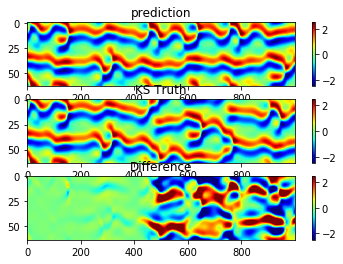

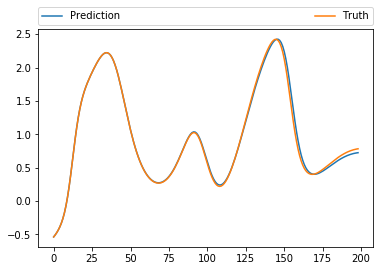

In [10]:
plt.subplot(311)
plt.imshow(predictions,interpolation='none',aspect='auto',vmin=-2.5,vmax=2.5,cmap='jet')
plt.title('Prediction');
plt.colorbar();
plt.subplot(312)
plt.imshow(data[:, resparams.train_length:resparams.train_length + resparams.predict_length],interpolation='none',aspect='auto',vmin=-2.5,vmax=2.5,cmap='jet')
plt.title('KS Truth');
plt.colorbar();
plt.subplot(313);
plt.imshow(data[:, resparams.train_length: resparams.train_length + resparams.predict_length] - predictions,interpolation='none',aspect='auto',vmin=-2.5,vmax=2.5,cmap='jet')
plt.title('Difference');
plt.colorbar();
plt.show()


plt.figure()
plt.plot(predictions.T[1:200,1], label= 'Prediction')
plt.plot(data[1, resparams.train_length:resparams.train_length+200-1],  label = 'Truth')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()